In [1]:
import numpy as np
import pandas as pd

In [2]:
def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
    rms = lambda sig: np.sqrt(np.mean(sig**2))
    nChannels,nSamples = rawDataMatrix.shape    
    I = int(np.floor(nSamples/(windowLength-windowOverlap)))
    featMatrix = np.zeros([nChannels, I])
    for channel in range(nChannels):
        for i in range (I):
            wdwStrtIdx=i*(windowLength-windowOverlap)
            sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)] 
            featMatrix[channel, i] = rms(sigWin)
    featMatrixData = np.array(featMatrix)
    return featMatrixData

In [37]:
import os

Fs = 500
windowLength = int(np.floor(0.1*Fs))  #160ms
windowOverlap =  int(np.floor(50/100 * windowLength))

train_features = np.zeros([0,8])
train_labels = np.zeros([0])
test_features = np.zeros([0,8])
test_labels = np.zeros([0])
for shift in range(0,5):
    for files in sorted(os.listdir(f'Subject_2/Shift_{shift}/')):
        _, class_,_, rep_ = files.split('_')
        df = pd.read_csv(f'Subject_2/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
        data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
        data_arr -= 121
        data_arr /= 255.0
        feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
        
        if not class_.startswith('9'):
            rms_feature = feaData.sum(0)
            baseline = 2*rms_feature[-50:].mean()
            start_ = np.argmax(rms_feature[::1]>baseline)
            end_  = -np.argmax(rms_feature[::-1]>baseline)
            feaData = feaData.T[start_:end_]
        else:
            feaData = feaData.T
        if rep_.startswith('5'):
            test_features = np.concatenate([test_features,feaData])
            test_labels = np.concatenate([test_labels,np.ones_like(feaData)[:,0]*int(class_)-1])
        else:
            train_features = np.concatenate([train_features,feaData])
            train_labels = np.concatenate([train_labels,np.ones_like(feaData)[:,0]*int(class_)-1])
    

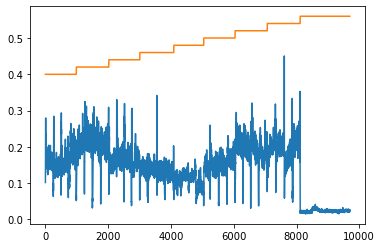

In [38]:
import matplotlib.pyplot as plt
plt.plot(train_features.sum(1))
plt.plot(train_labels/50+ 0.4)

In [60]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(penalty='l2', C=10000).fit(train_features, train_labels)
reg.score(train_features, train_labels), reg.score(test_features, test_labels)

/u/61/dinhm2/unix/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9612291194060631, 0.8099109562524197)

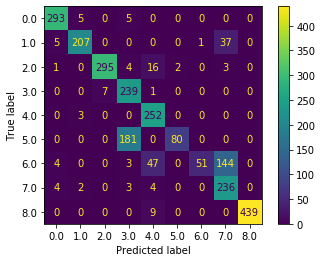

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, reg.predict(test_features)),
                            display_labels=reg.classes_)
disp.plot()

In [62]:
from joblib import dump, load
dump(reg, 'LogisticRegression.joblib') 

['LogisticRegression.joblib']

In [58]:
accuracy_grid = np.zeros([3,3])
accuracy_list = []
for shift in range(0,5):
    test_features = np.zeros([0,8])
    test_labels = np.zeros([0])
    for files in sorted(os.listdir(f'Subject_2/Shift_{shift}/')):
        _, class_,_, rep_ = files.split('_')
        df = pd.read_csv(f'Subject_2/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
        data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
        data_arr -= 121
        data_arr /= 255.0
        feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
        
        if not class_.startswith('9'):
            rms_feature = feaData.sum(0)
            baseline = 2*rms_feature[-50:].mean()
            start_ = np.argmax(rms_feature[::1]>baseline)
            end_  = -np.argmax(rms_feature[::-1]>baseline)
            feaData = feaData.T[start_:end_]
        else:
            feaData = feaData.T
        if rep_.startswith('5'):
            test_features = np.concatenate([test_features,feaData])
            test_labels = np.concatenate([test_labels,np.ones_like(feaData)[:,0]*int(class_)-1])
    accuracy_list += [reg.score(test_features,test_labels)]


In [59]:
accuracy_list

[0.908987915407855,
 0.3313161875945537,
 0.37494044783230107,
 0.9063981042654028,
 0.8230739450251645]